In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-03_16-58_20180601_20191231_th70_per24_sm10.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

NQ       0.25
GC       0.25
YM       0.25
ES       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    27465.90
GC     7257.72
NQ    33948.60
YM    36697.80
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

105370.02

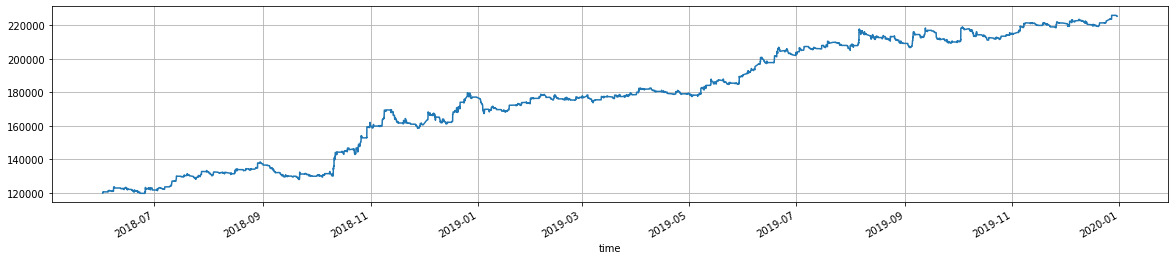

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     546
 GC    1035
 NQ    2034
 YM     582
 Name: action, dtype: int64,
 4197)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.325243
 GC    2.512136
 NQ    4.936893
 YM    1.412621
 Name: action, dtype: float64,
 10.186893203883495)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1146.6
GC    2504.7
NQ    4271.4
YM    1222.2
Name: commission, dtype: float64

In [15]:
df.commission.sum()

9144.900000000001

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,14.04,455.56,-264.52,1.72,16.31,517.0
NQ,0.41,33.38,448.80,-251.83,1.78,35.43,1017.0
ES,0.41,100.61,956.96,-495.12,1.93,100.23,273.0
YM,0.43,126.11,783.54,-375.93,2.08,122.64,291.0
total,0.41,50.22,566.69,-302.93,1.87,53.61,2098.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.013011,0.201269,0.487056,0.712034
GC,-0.013011,1.000000,0.073721,0.040579,0.359002
NQ,0.201269,0.073721,1.000000,0.281521,0.650998
YM,0.487056,0.040579,0.281521,1.000000,0.744872
total,0.712034,0.359002,0.650998,0.744872,1.000000


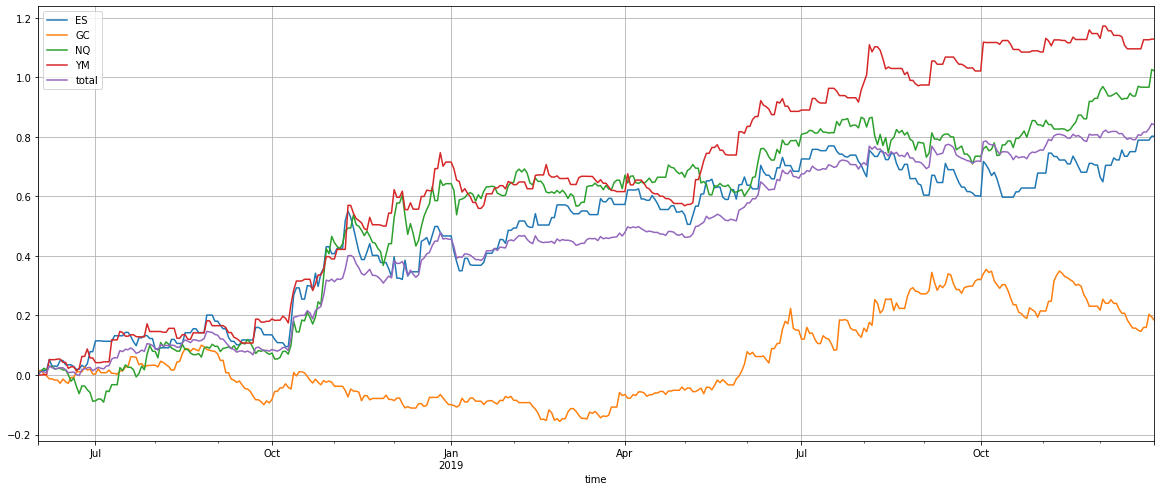

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

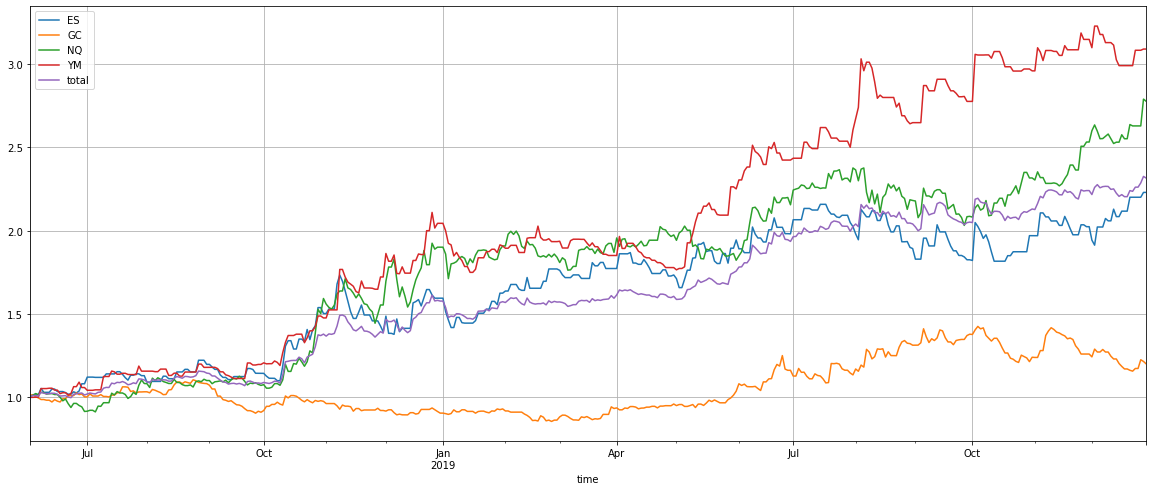

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.633181,0.118423,0.867490,0.993872,0.671430
Cumulative returns,1.229945,0.200790,1.776423,2.090163,1.315962
Annual volatility,0.376522,0.271032,0.368192,0.344654,0.216167
Sharpe ratio,1.487255,0.545961,1.879880,2.170896,2.484560
Calmar ratio,3.087505,0.524031,5.507713,5.828243,7.509105
Stability,0.860984,0.456521,0.864690,0.946908,0.958076
Max drawdown,-0.205078,-0.225985,-0.157505,-0.170527,-0.089415
Omega ratio,1.393747,1.111884,1.418983,1.723711,1.641946
Sortino ratio,2.891150,0.969575,3.280057,5.087103,5.448545
Skew,1.541153,1.527448,0.706640,2.411282,1.900370


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,8.16,0.30,-8.45,5.90,1.43
2018-07-31,4.50,3.03,18.33,9.28,8.87
2018-08-31,6.00,4.76,1.64,1.96,3.76
2018-09-30,-4.46,-15.87,-2.64,1.50,-5.45
2018-10-31,31.32,7.18,48.64,23.30,27.36
2018-11-30,-7.32,-5.62,-2.44,16.65,0.44
2018-12-31,14.50,-1.72,22.32,18.69,13.87
2019-01-31,1.90,2.79,0.39,-6.65,-0.24
2019-02-28,8.93,-7.23,-3.55,1.37,-0.14


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       123.0
GC        20.0
NQ       178.0
YM       209.0
total    132.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 19:26:30,YM,SELL,26188.00,4775.8
2019-10-02 20:32:30,ES,BUY,2885.25,3745.8
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
2018-12-17 17:03:00,ES,BUY,2597.00,3233.3
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
...,...,...,...,...
2018-11-13 19:11:00,ES,SELL,2731.00,-1166.7
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.101107,0.057183,0.084467,0.048607,0.072841
2019-09-05,0.068887,0.063344,0.070387,0.084053,0.071668
2019-10-02,0.124860,0.020021,0.026633,0.101693,0.068302
2019-08-05,0.093470,0.032011,0.030293,0.106360,0.065534
2018-12-03,0.067777,-0.003989,0.091913,0.081860,0.059390
...,...,...,...,...,...
2018-11-13,-0.038890,0.000011,-0.032007,-0.017613,-0.022125
2019-09-18,-0.022640,-0.018656,-0.042393,-0.013140,-0.024207
2019-01-02,-0.050973,-0.003495,-0.021780,-0.022307,-0.024639
